# Hoja de trabajo: Detección de DGA

Para este ejercicio usaremos las siguientes librerías:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)
* Scikit-learn (http://scikit-learn.org/stable/documentation.html)
* YellowBrick (http://www.scikit-yb.org/en/latest/)
* Seaborn (https://seaborn.pydata.org)

In [1]:
#Importar las librerías

import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

## TRABAJADO POR :
### JUAN MARROQUIN 19845
### CARLOS RAXTUM 19751

## Parte 1: Ingeniería de características

In [2]:
## Cargar el dataset proporcionado
df = pd.read_csv('dga_data_small.csv')
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.sample(n=5).head() # print a random sample of the DataFrame

(2000, 2)


,isDGA,domain
1579,legit,meezanbank
1696,legit,forumnov
1889,legit,hab-inc
1031,legit,hastane
871,dga,1ysb4ymdb6rmp1mopyk91qeq3l4


In [3]:
df[df.isDGA == 'legit'].sample(5)

,isDGA,domain
1305,legit,extreme
1331,legit,prestitisupermarket
1756,legit,manotopic
1884,legit,aec-internet
1222,legit,royalcm


In [4]:
df[df.isDGA == 'dga'].sample(5)

,isDGA,domain
883,dga,jpwbqhkkonjsn
610,dga,mqqxvpdngqgssgh
700,dga,spokepast
538,dga,yyliapgwldql
649,dga,homwrphksavjaps


**Lista de características a derivar (basado en artículos académicos)**:

1. Length ["length"]
2. Number of digits ["digits"]
3. Entropy ["entropy"] - use ```H_entropy```
4. Vowel to consonant ratio ["vowel-cons"] - use ```vowel_consonant_ratio```
5. The index of the first digit - use the ``firstDigitIndex`` 
6. n-grams

In [5]:
from six.moves import cPickle as pickle
with open('d_common_en_words' + '.pickle', 'rb') as f:
        d = pickle.load(f)

def H_entropy (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [6]:
df['ngrams'] = df['domain'].apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1), 
                                                                ngram_feature(x, d, 2), 
                                                                ngram_feature(x, d, 3)]))

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
df.sample(10)
df['entropy'] = df['domain'].apply(H_entropy)
df['vowel-cons'] = df['domain'].apply(vowel_consonant_ratio)
df['firstDigitIndex'] = df['domain'].apply(firstDigitIndex)
# Calcular las características faltantes length y digits
# Su código:

df['length'] = df.domain.apply(len)
df['digits'] = df.domain.apply(lambda x:sum(c.isdigit() for c in x))


# Codifique para la columna isDGA: dga con el valor 1, y legit con el valor 0
# Su código

df['isDGA'] = np.where(df['isDGA'] == 'dga', 1, 0)

print(df['isDGA'].value_counts())
df.sample(n=5).head()


1    1000
0    1000
Name: isDGA, dtype: int64


,isDGA,domain,ngrams,entropy,vowel-cons,firstDigitIndex,length,digits
980,1,lcdxoafsqyyek,903.878594,3.546594,0.300000,0,13,0
1718,0,cosmicbooknews,1281.459707,3.182006,0.555556,0,14,0
232,1,cloudcross,1309.065741,2.721928,0.428571,0,10,0
1055,0,mundomedia,1389.825000,2.921928,1.000000,0,10,0
6,1,dtvbafg,835.482540,2.807355,0.166667,0,7,0


In [7]:
df_final = df
df_final = df_final.drop(['domain'], axis=1)
df_final.to_csv('dga_features_final_df.csv', index=False)
df_final.head()

,isDGA,ngrams,entropy,vowel-cons,firstDigitIndex,length,digits
0,1,744.670940,3.546594,0.083333,0,13,0
1,1,715.217265,4.132944,0.333333,1,26,10
2,1,1918.797619,2.500000,0.333333,0,8,0
3,1,682.269402,4.180833,0.357143,1,26,7
4,1,544.178140,3.834963,0.666667,2,24,9


## Visualización de la data

In [8]:
feature_names = ['length','digits','entropy','vowel-cons','firstDigitIndex', 'ngrams']
features = df_final[feature_names]
target = df_final['isDGA']

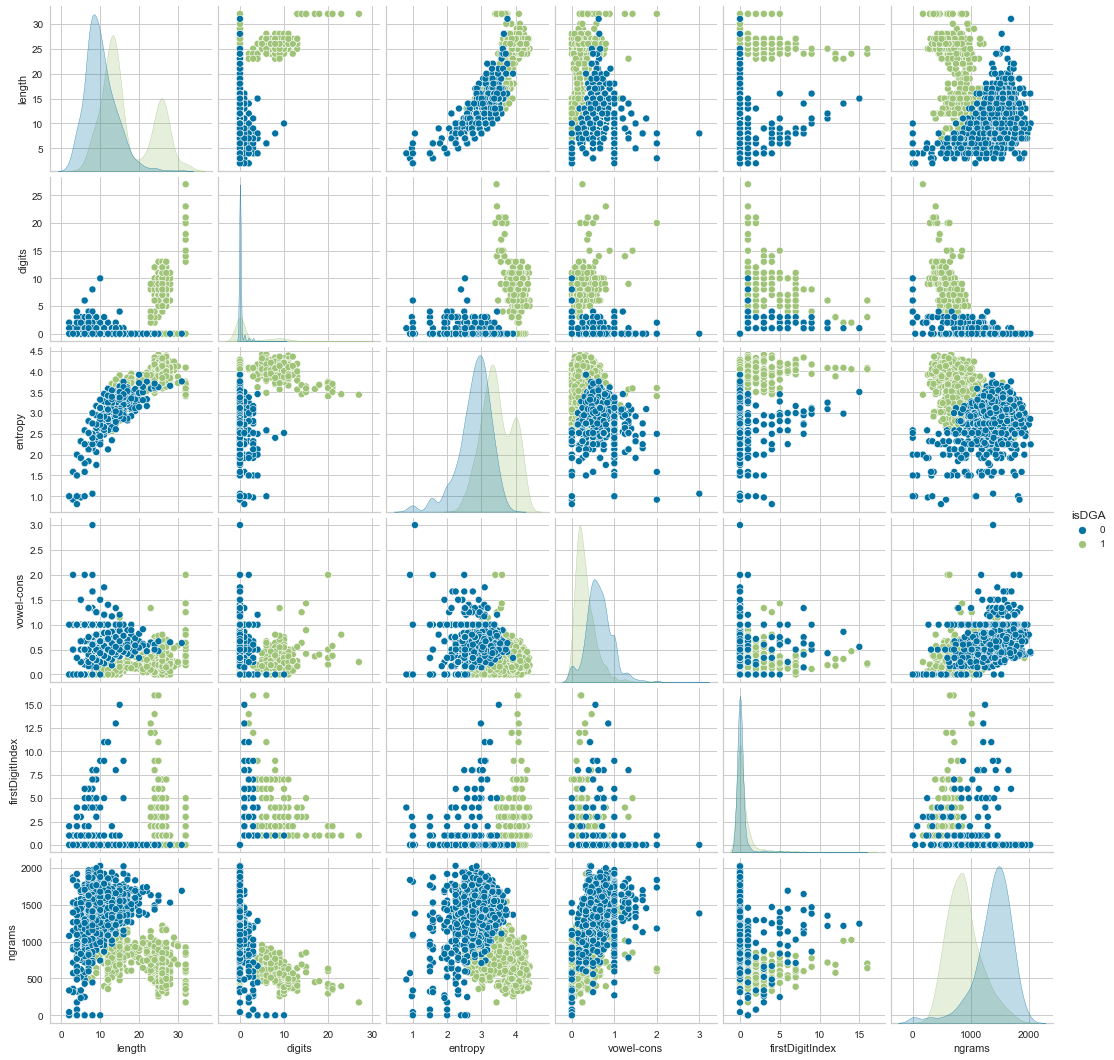

In [9]:
sns.pairplot(df_final, hue='isDGA', vars=feature_names)

Explique cómo se interpreta la característica entropy contra cualquiera de las demas características

Gráfica elegida e interpretación:

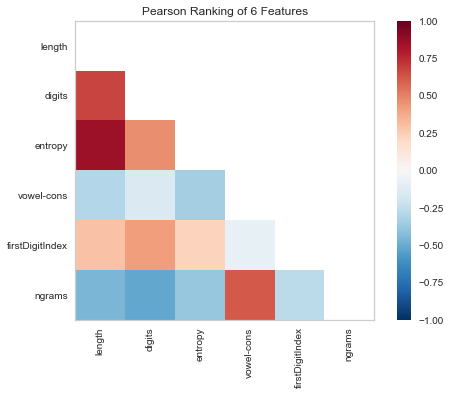

<AxesSubplot:title={'center':'Pearson Ranking of 6 Features'}>

In [10]:
visualizer = Rank2D(algorithm='pearson',features=feature_names)
visualizer.fit_transform( features )
visualizer.poof()

Explique cómo se interpreta la correlación entre las características entropy y length

Respuesta:


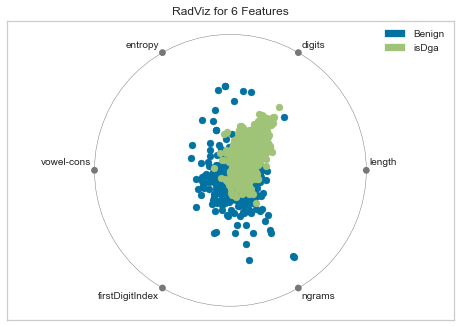

<AxesSubplot:title={'center':'RadViz for 6 Features'}>

In [11]:
features = df_final[feature_names].values
target = df_final['isDGA'].values

radvizualizer = RadViz(classes=['Benign','isDga'], features=feature_names)
radvizualizer.fit_transform( features, target)
radvizualizer.poof()

Interprete el gráfico generado por el algoritmo Radviz

Respuesta: 

## Parte 2: Implementación del modelo

### Paso 1: Prepare la matriz de características y el vector Target

- En estadistica, la matriz de características es normalmente conocida como ```X```
- Target es un vector que contiene las etiquetas para cada URL (también conocido como  *y* en estadistica)
- En sklearnel X y el Objetivo pueden ser ambos pandas DataFrame/Series o numpy array/vector (no pueden ser listas!)

Tarea:
- asigne la columna 'isDGA' a una serie de pandas y nombrela 'target'
- Elimine la columna 'isDGA' del dataFrame ```dga``` y nombre el DataFrame resultante como 'feature_matrix'

In [12]:
target = df_final['isDGA']
feature_matrix = df_final.drop(['isDGA'], axis=1)
print('Final features', feature_matrix.columns)

feature_matrix.head()

Final features Index(['ngrams', 'entropy', 'vowel-cons', 'firstDigitIndex', 'length',
       'digits'],
      dtype='object')


,ngrams,entropy,vowel-cons,firstDigitIndex,length,digits
0,744.670940,3.546594,0.083333,0,13,0
1,715.217265,4.132944,0.333333,1,26,10
2,1918.797619,2.500000,0.333333,0,8,0
3,682.269402,4.180833,0.357143,1,26,7
4,544.178140,3.834963,0.666667,2,24,9


### Paso 2: Separación de datos

- Divida el dataset en datos de entrenamiento (75%) y prueba (25%), en las variables feature_matrix_train, feature_matrix_test, target_train, target_test

In [13]:
#Su código
feature_matrix_train, feature_matrix_test, target_train, target_test = train_test_split(feature_matrix, target, test_size=0.25, random_state=42)

In [14]:
feature_matrix_train.count()

ngrams             1500
entropy            1500
vowel-cons         1500
firstDigitIndex    1500
length             1500
digits             1500
dtype: int64

In [15]:
feature_matrix_test.count()

ngrams             500
entropy            500
vowel-cons         500
firstDigitIndex    500
length             500
digits             500
dtype: int64

In [16]:
target_train.head()

1738    0
548     1
936     1
1389    0
1607    0
Name: isDGA, dtype: int32

In [17]:
target_train.value_counts()

0    757
1    743
Name: isDGA, dtype: int64

### Paso 3: Entrenamiento del modelo

- Use el modelo de árbol de decisión de sklearn [tree.DecisionTreeClassfier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), y cree un modelo con los parámetros estandar , luego entrenelo usando la función ```.fit()``` con la data ```X_train``` y ```target_train```.

In [18]:
clf = tree.DecisionTreeClassifier()  # clf means classifier
clf = clf.fit(feature_matrix_train, target_train)

# Extract a row from the test data
test_feature = feature_matrix_test[192:193]
test_target = target_test[192:193]

# Make the prediction
pred = clf.predict(test_feature)
print('Predicted class:', pred)
print('Accurate prediction?', pred[0] == test_target)

Predicted class: [0]
Accurate prediction? 1384    True
Name: isDGA, dtype: bool


In [19]:
pred[0] == test_target

1384    True
Name: isDGA, dtype: bool

### Paso 4: Predicciones

- Para poder hacer predicciones con el modelo, se deben derivar las características de las URLs de prueba

In [20]:
def is_dga(domain, clf, d):
    # Parámetros: dominio y el modelo entrenado clf
    # Retorna una predicción 
    
    domain_features = np.empty([1,6])
    # orden de las características ['length', 'digits', 'entropy', 'vowel-cons', firstDigitIndex]
    domain_features[0,0] = len(domain)
    pattern = re.compile('([0-9])')
    domain_features[0,1] = len(re.findall(pattern, domain))
    domain_features[0,2] = H_entropy(domain)
    domain_features[0,3] = vowel_consonant_ratio(domain)
    domain_features[0,4] = firstDigitIndex(domain)
    domain_features[0,5] = average_ngram_feature([ngram_feature(domain, d, 1), 
                                                  ngram_feature(domain, d, 2), 
                                                  ngram_feature(domain, d, 3)])
    pred = clf.predict(domain_features)
    return pred[0]

Utilice la función is_dga para realizar predicciones sobre los siguientes dominios de prueba:

- microsoft
- google
- 1vxznov16031kjxneqjk1rtofi6

In [21]:
#Su código
print('the domain microsoft is dga: ',True if is_dga('microsoft',clf,d) == 1 else False)
print('the domain google is dga: ',True if is_dga('google',clf,d) == 1 else False)
print('the domain 1vxznov16031kjxneqjk1rtofi6 is dga: ',True if is_dga('1vxznov16031kjxneqjk1rtofi6',clf,d) == 1 else False)

the domain microsoft is dga:  False
the domain google is dga:  False
the domain 1vxznov16031kjxneqjk1rtofi6 is dga:  True


C:\Users\JMarroquin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\JMarroquin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\JMarroquin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### Paso 5: Validación

- Cálculo de la matriz de validación

In [22]:
target_pred = clf.predict(feature_matrix_test)
print(metrics.accuracy_score(target_test, target_pred))
print('Confusion Matrix\n', metrics.confusion_matrix(target_test, target_pred))

0.878
Confusion Matrix
 [[211  32]
 [ 29 228]]


Etiquete de forma apropiada la matriz, y explique el valor de:

- Verdaderos positivos
- Verdaderos negativos
- Falsos positivos
- Falsos negativos

In [23]:
print(metrics.classification_report(target_test, target_pred, target_names=['legit', 'dga']))

              precision    recall  f1-score   support

       legit       0.88      0.87      0.87       243
         dga       0.88      0.89      0.88       257

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



Explique qué significa el valor de las métricas de precision, recall y f1-score

## TRABAJADO POR :
### JUAN MARROQUIN 19845
### CARLOS RAXTUM 19751